Mount my google drive, where I stored the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Download dependencies**

In [ ]:
!pip3 install sklearn matplotlib GPUtil

In [ ]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html

**Download Data**

In order to acquire the dataset please navigate to:

https://ieee-dataport.org/documents/cervigram-image-dataset

Unzip the dataset into the folder "dataset".

For your environment, please adjust the paths accordingly.

In [ ]:
!rm -vrf "../dataset"
!mkdir "../dataset"
# !cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!cp -r "../cervigram-image-dataset-v2.zip" "../dataset/cervigram-image-dataset-v2.zip"
!unzip "../dataset/cervigram-image-dataset-v2.zip" -d "../dataset"

**Constants**

For your environment, please modify the paths accordingly.  

In [1]:
# TRAIN_PATH = '/content/dataset/data/train/'
# TEST_PATH = '/content/dataset/data/test/'
TRAIN_PATH = '../dataset/data/train/'
TEST_PATH = '../dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 100

**Imports**

In [2]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random
import GPUtil

**Memory Stats**

In [3]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB
GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB


**Deterministic Measurements**

This statements help making the experiments reproducible by fixing the random seeds. Despite fixing the random seeds, experiments are usually not reproducible using different PyTorch releases, commits, platforms or between CPU and GPU executions. Please find more details in the PyTorch documentation:

https://pytorch.org/docs/stable/notes/randomness.html

In [4]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Loading Data**

The dataset is structured in multiple small folders of 7 images each. This generator iterates through the folders and returns the category and 7 paths: one for each image in the folder. The paths are ordered; the order is important since each folder contains 3 types of images, first 5 are with acetic acid solution and the last two are through a green lens and having iodine solution(a solution of a dark red color).

In [5]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which load 3 kinds of images: natural images, images taken through a green lens and images where the doctor applied iodine solution (which gives a dark red color). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data. 

In [6]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [7]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [8]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [9]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [10]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(SimpleImagesDataset)

**Visualize Data**

Load a few images so that we can see the effects of the data augmentation on the training set.

In [11]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [12]:
# x, y = next(iter(loader_train_simple_img))
# plot_predictions(x, y, y)

**Model**

Define a few models to experiment with.

In [13]:
def get_mobilenet_v2():
  model = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
  model.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  model = model.cuda()
  return model

def get_vgg_19():
  model = tv.models.vgg19(pretrained = True)
  model = model.cuda()
  model.classifier[6].out_features = 4
  return model

def get_res_next_101():
  model = t.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
  model.fc.out_features = 4
  model = model.cuda()
  return model

def get_resnet_18():
  model = tv.models.resnet18(pretrained = True)
  model.fc.out_features = 4
  model = model.cuda()
  return model

def get_dense_net():
  model = tv.models.densenet121(pretrained = True)
  model.classifier.out_features = 4
  model = model.cuda()
  return model

class MobileNetV2_FullConv(t.nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = get_mobilenet_v2().features
    self.cnn[18] = t.nn.Sequential(
      tv.models.mobilenet.ConvBNReLU(320, 32, kernel_size=1),
      t.nn.Dropout2d(p = .7)
    )
    self.fc = t.nn.Linear(32, 4)

  def forward(self, x):
    x = self.cnn(x)
    x = x.mean([2, 3])
    x = self.fc(x);
    return x

In [14]:
model_simple = t.nn.DataParallel(get_dense_net())

**Train & Evaluate**

Timer utility function. This is used to measure the execution speed.

In [15]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and evaluates it at the same time. It outputs the metrics recorded during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is improved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [16]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],

      'acc_train': [],
      'acc_test': [],

      'prec_train': [],
      'prec_test': [],

      'rec_train': [],
      'rec_test': [],

      'f_score_train': [],
      'f_score_test': []
  }

  best_acc = 0
  
  loss_fn = t.nn.CrossEntropyLoss()
    
  try:  
    for epoch in range(epochs):
      timer_start()
      train_epoch_loss, train_epoch_acc, train_epoch_precision, train_epoch_recall, train_epoch_f_score = 0, 0, 0, 0, 0
      test_epoch_loss, test_epoch_acc, test_epoch_precision, test_epoch_recall, test_epoch_f_score = 0, 0, 0, 0, 0

      # Train
      model.train()
      for x, y in loader_train:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
#         memory_stats()
        optimizer.zero_grad()
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_train
        train_epoch_loss += (loss.item() * ratio)
        train_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio)
        precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
        train_epoch_precision += (precision * ratio)
        train_epoch_recall += (recall * ratio)
        train_epoch_f_score += (f_score * ratio)
      metrics['losses_train'].append(train_epoch_loss)
      metrics['acc_train'].append(train_epoch_acc)
      metrics['prec_train'].append(train_epoch_precision)
      metrics['rec_train'].append(train_epoch_recall)
      metrics['f_score_train'].append(train_epoch_f_score)
  
      # Evaluate
      model.eval()
      with t.no_grad():
        for x, y in loader_test:
          y_pred = model.forward(x)
          loss = loss_fn(y_pred, y)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          pred = y_pred.argmax(axis = 1)
          ratio = len(y) / len_test
          test_epoch_loss += (loss * ratio)
          test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
          precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
          test_epoch_precision += (precision * ratio)
          test_epoch_recall += (recall * ratio)
          test_epoch_f_score += (f_score * ratio)
        metrics['losses_test'].append(test_epoch_loss)
        metrics['acc_test'].append(test_epoch_acc)
        metrics['prec_test'].append(test_epoch_precision)
        metrics['rec_test'].append(test_epoch_recall)
        metrics['f_score_test'].append(test_epoch_f_score)
      
      if metrics['acc_test'][-1] > best_acc:
        best_acc = metrics['acc_test'][-1]
        t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
      print('Epoch {} acc {} prec {} rec {} f {} minutes {}'.format(
        epoch + 1, metrics['acc_test'][-1], metrics['prec_test'][-1], metrics['rec_test'][-1], metrics['f_score_test'][-1], timer_end() / 60))
  except KeyboardInterrupt as e:
    print(e)  
  print('Ended training')
  return metrics

Plot a metric for both train and test.

In [17]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

Plot precision - recall curve

In [18]:
def plot_precision_recall(metrics):
    plt.scatter(metrics['prec_train'], metrics['rec_train'], label = 'train')
    plt.scatter(metrics['prec_test'], metrics['rec_test'], label = 'test')
    plt.legend()
    plt.title('Precision-Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [19]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    print('Best test accuracy :', max(metrics['acc_test']))
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate))
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate))

Perform actual training.

In [20]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  t.cuda.empty_cache()
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    
    index_max = np.array(metrics['acc_test']).argmax()
    print('Best test accuracy :', metrics['acc_test'][index_max])
    print('Corresponding precision :', metrics['prec_test'][index_max])
    print('Corresponding recall :', metrics['rec_test'][index_max])
    print('Corresponding f1 score :', metrics['f_score_test'][index_max])

    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate), 'Loss')
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate), 'Accuracy')
    plot_train_test(metrics['prec_train'], metrics['prec_test'], 'Precision (lr = {})'.format(learn_rate), 'Precision')
    plot_train_test(metrics['rec_train'], metrics['rec_test'], 'Recall (lr = {})'.format(learn_rate), 'Recall')
    plot_train_test(metrics['f_score_train'], metrics['f_score_test'], 'F1 Score (lr = {})'.format(learn_rate), 'F1 Score')
    plot_precision_recall(metrics)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 acc 0.25833333333333336 prec 0.03224541348165706 rec 0.014245536806065053 f 0.016361726640523412 minutes 0.409659751256307
Epoch 2 acc 0.5625 prec 0.4154435841935843 rec 0.328125 f 0.33947127221583745 minutes 0.27408066590627034
Epoch 3 acc 0.5875 prec 0.4537510486434425 rec 0.34427083333333336 f 0.38082222248459224 minutes 0.27404218514760337
Epoch 4 acc 0.5541666666666667 prec 0.517399574211526 rec 0.3506944444444445 f 0.40567484761232947 minutes 0.27210961977640785
Epoch 5 acc 0.6083333333333333 prec 0.550737680536478 rec 0.38240740740740736 f 0.43709688597180063 minutes 0.2753602703412374
Epoch 6 acc 0.5875 prec 0.512973137973138 rec 0.3592592592592593 f 0.4100619542777496 minutes 0.2730940659840902
Epoch 7 acc 0.6250000000000001 prec 0.5116894753991529 rec 0.36967592592592596 f 0.4208675741562499 minutes 0.27589853207270304
Epoch 8 acc 0.6666666666666667 prec 0.47422164957331203 rec 0.3588541666666667 f 0.39821344022460026 minutes 0.2748596866925557
Epoch 9 acc 0.6 prec 0.

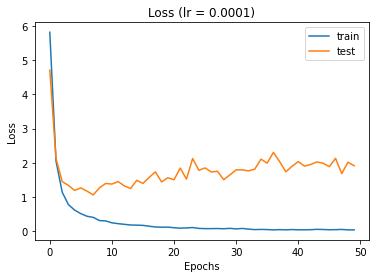

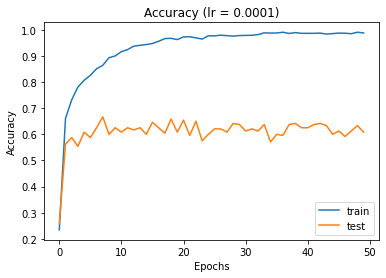

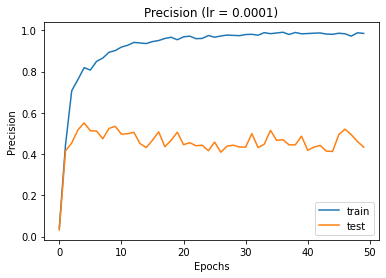

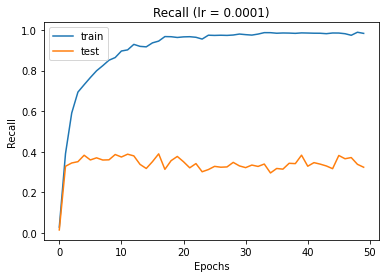

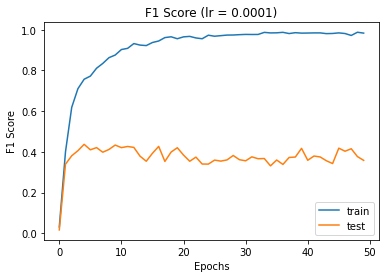

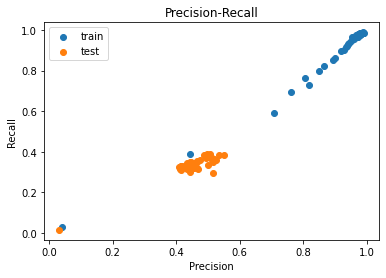

In [21]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'densenet_baseline', [(50, 1e-4)])

In [ ]:
# checkpoint = t.load('/content/checkpint simple_1.tar')
# model_simple.load_state_dict(checkpoint['model'])